In [ ]:
# dowaload the packge if needed
! pip install matplotlib statsmodels
! pip install pandas numpy matplotlib seaborn statsmodels


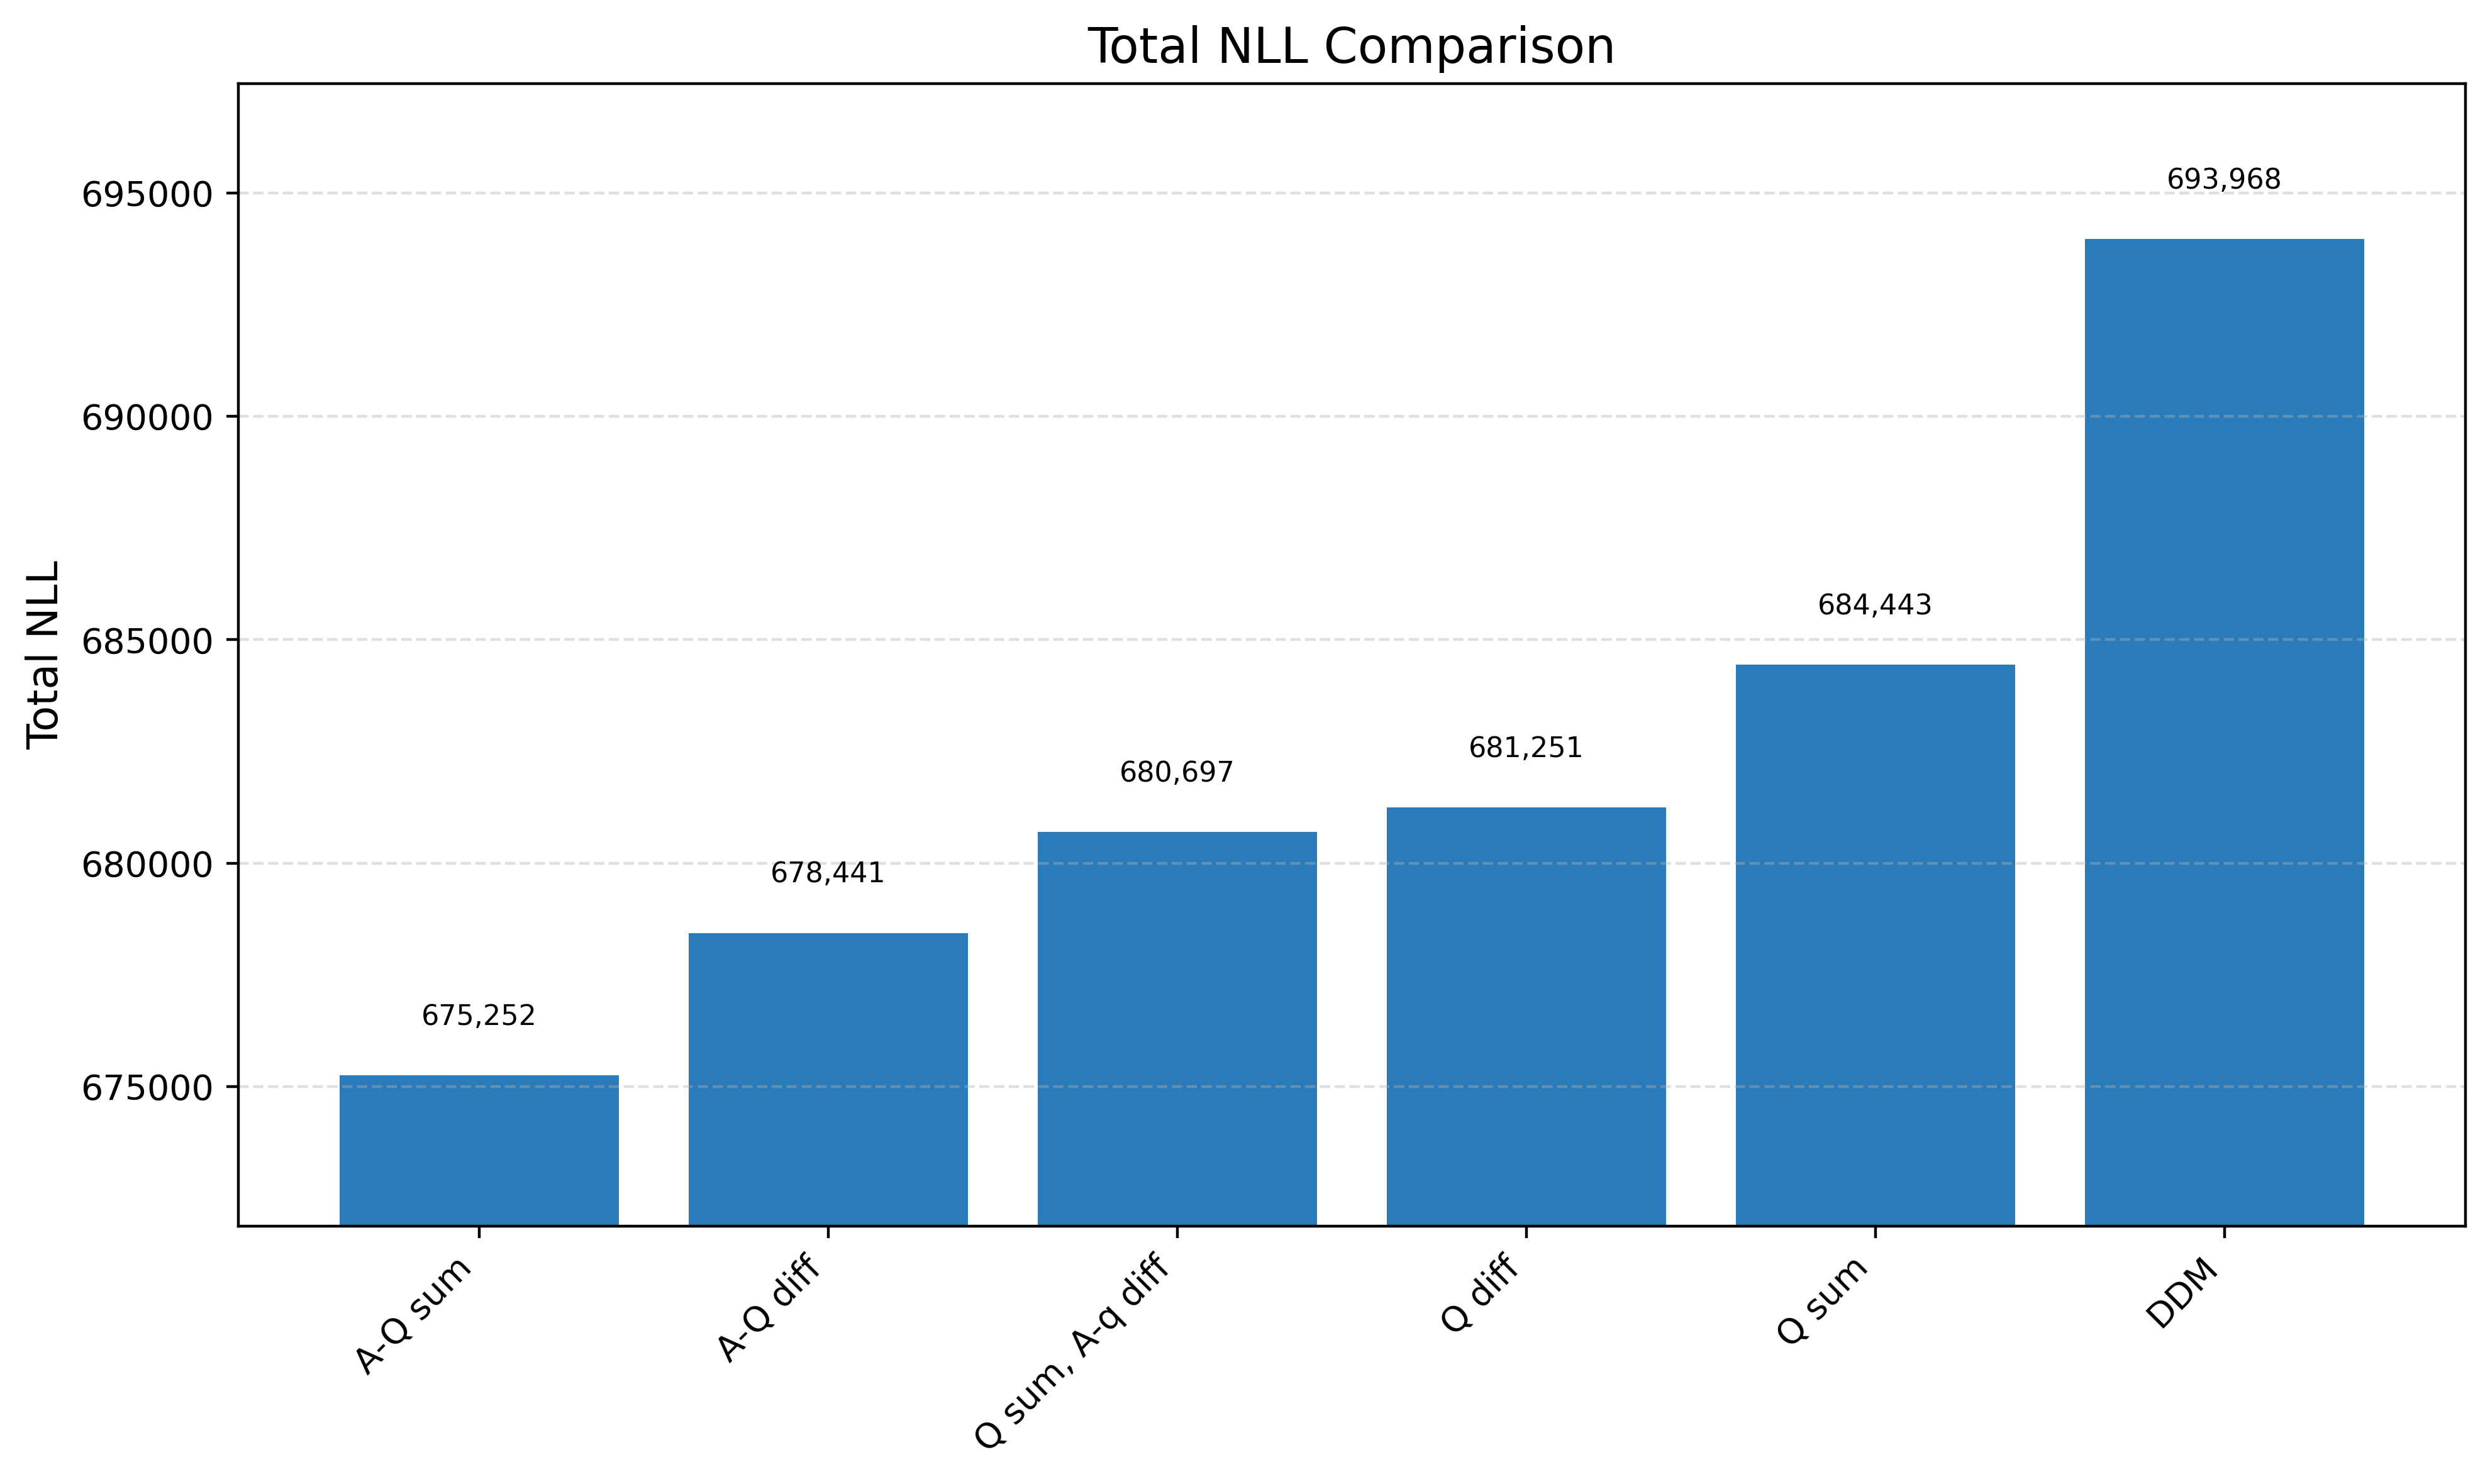

In [1]:
# model comprasion. I sum them together by hand. 
import matplotlib.pyplot as plt

model_nlls = {
    'DDM': 693968.2516, # 2(how many parameters if used for AIC or BIC, but wont be needed as they are appromxialy the same)
    'Q diff': 681251.4047, # 3
    'Q sum': 684443.3046, # 3
    'A-Q sum': 675251.64,# 4
    'A-Q diff': 678441.21,#4
    'Q sum, A-q diff': 680697.34#4
}

sorted_items = sorted(model_nlls.items(), key=lambda x: x[1])
sorted_names = [item[0] for item in sorted_items]
sorted_nlls = [item[1] for item in sorted_items]

plt.figure(figsize=(10, 6), dpi=400)
bars = plt.bar(sorted_names, sorted_nlls, color='#2a7bba')
plt.ylabel('Total NLL', fontsize=12)
plt.title('Total NLL Comparison', fontsize=14)
plt.ylim(min(sorted_nlls) * 0.995, max(sorted_nlls) * 1.005)  

for bar, val in zip(bars, sorted_nlls):
    plt.text(bar.get_x() + bar.get_width() / 2, val + 1000, f"{val:,.0f}",
             ha='center', va='bottom', fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [2]:
# heatmap function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from itertools import combinations

female_color = '#D55672' 
male_color = '#0075A2'   
femaleIDs = {'rat150', 'rat152', 'rat224', 'rat225', 'rat228'}
param_list = ['k', 'a', 'w', 'T']  

def plot_param_correlation_heatmap_lme(csv_path, param_list):
    df = pd.read_csv(csv_path)
    df['sex'] = df['ratID'].apply(lambda r: 'female' if r in femaleIDs else 'male')

    def get_stars(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return ''

    def fit_lme_nested_correlation(df, param_x, param_y):
        df = df.dropna(subset=[param_x, param_y]).copy()
        df["rat_section"] = df["ratID"] + "_" + df["sectionID"].astype(str)
        model = smf.mixedlm(f"{param_y} ~ {param_x}", df, groups=df["ratID"],
                            vc_formula={"rat_section": "0 + C(rat_section)"})
        result = model.fit(reml=False)
        coef = result.params.get(param_x, np.nan)
        p_val = result.pvalues.get(param_x, np.nan)
        return coef, p_val

    def run_and_plot(sex):
        sex_df = df[df['sex'] == sex].copy()
        coef_matrix = pd.DataFrame(index=param_list, columns=param_list, dtype=float)
        pval_matrix = pd.DataFrame(index=param_list, columns=param_list, dtype=float)

        for param_x, param_y in combinations(param_list, 2):
            coef, p_val = fit_lme_nested_correlation(sex_df, param_x, param_y)
            coef_matrix.loc[param_y, param_x] = coef
            pval_matrix.loc[param_y, param_x] = p_val
            coef_matrix.loc[param_x, param_y] = coef
            pval_matrix.loc[param_x, param_y] = p_val

        np.fill_diagonal(coef_matrix.values, 0)
        np.fill_diagonal(pval_matrix.values, 1)

        cmap = sns.diverging_palette(250, 10, as_cmap=True)  

        plt.figure(figsize=(5, 5), dpi=400)
        ax = sns.heatmap(coef_matrix.astype(float), annot=False, cmap=cmap, center=0, cbar=True, square=True)

        for i in range(len(param_list)):
            for j in range(len(param_list)):
                coef_val = coef_matrix.iloc[i, j]
                p_val = pval_matrix.iloc[i, j]
                text = f"{coef_val:.2f}" if not np.isnan(coef_val) else ""
                plt.text(j + 0.5, i + 0.6, text, ha='center', va='center', color='black', fontsize=8)

                star = get_stars(p_val)
                if star:
                    plt.text(j + 0.5, i + 0.4, star, ha='center', va='center', color='black', fontsize=10)

        plt.xticks(np.arange(len(param_list)) + 0.5, param_list, rotation=45, ha='right')
        plt.yticks(np.arange(len(param_list)) + 0.5, param_list, rotation=0)
        plt.title(f'{sex.capitalize()} Correlation Heatmap (LME)')
        plt.tight_layout()
        plt.show()

    run_and_plot('male')
    run_and_plot('female')




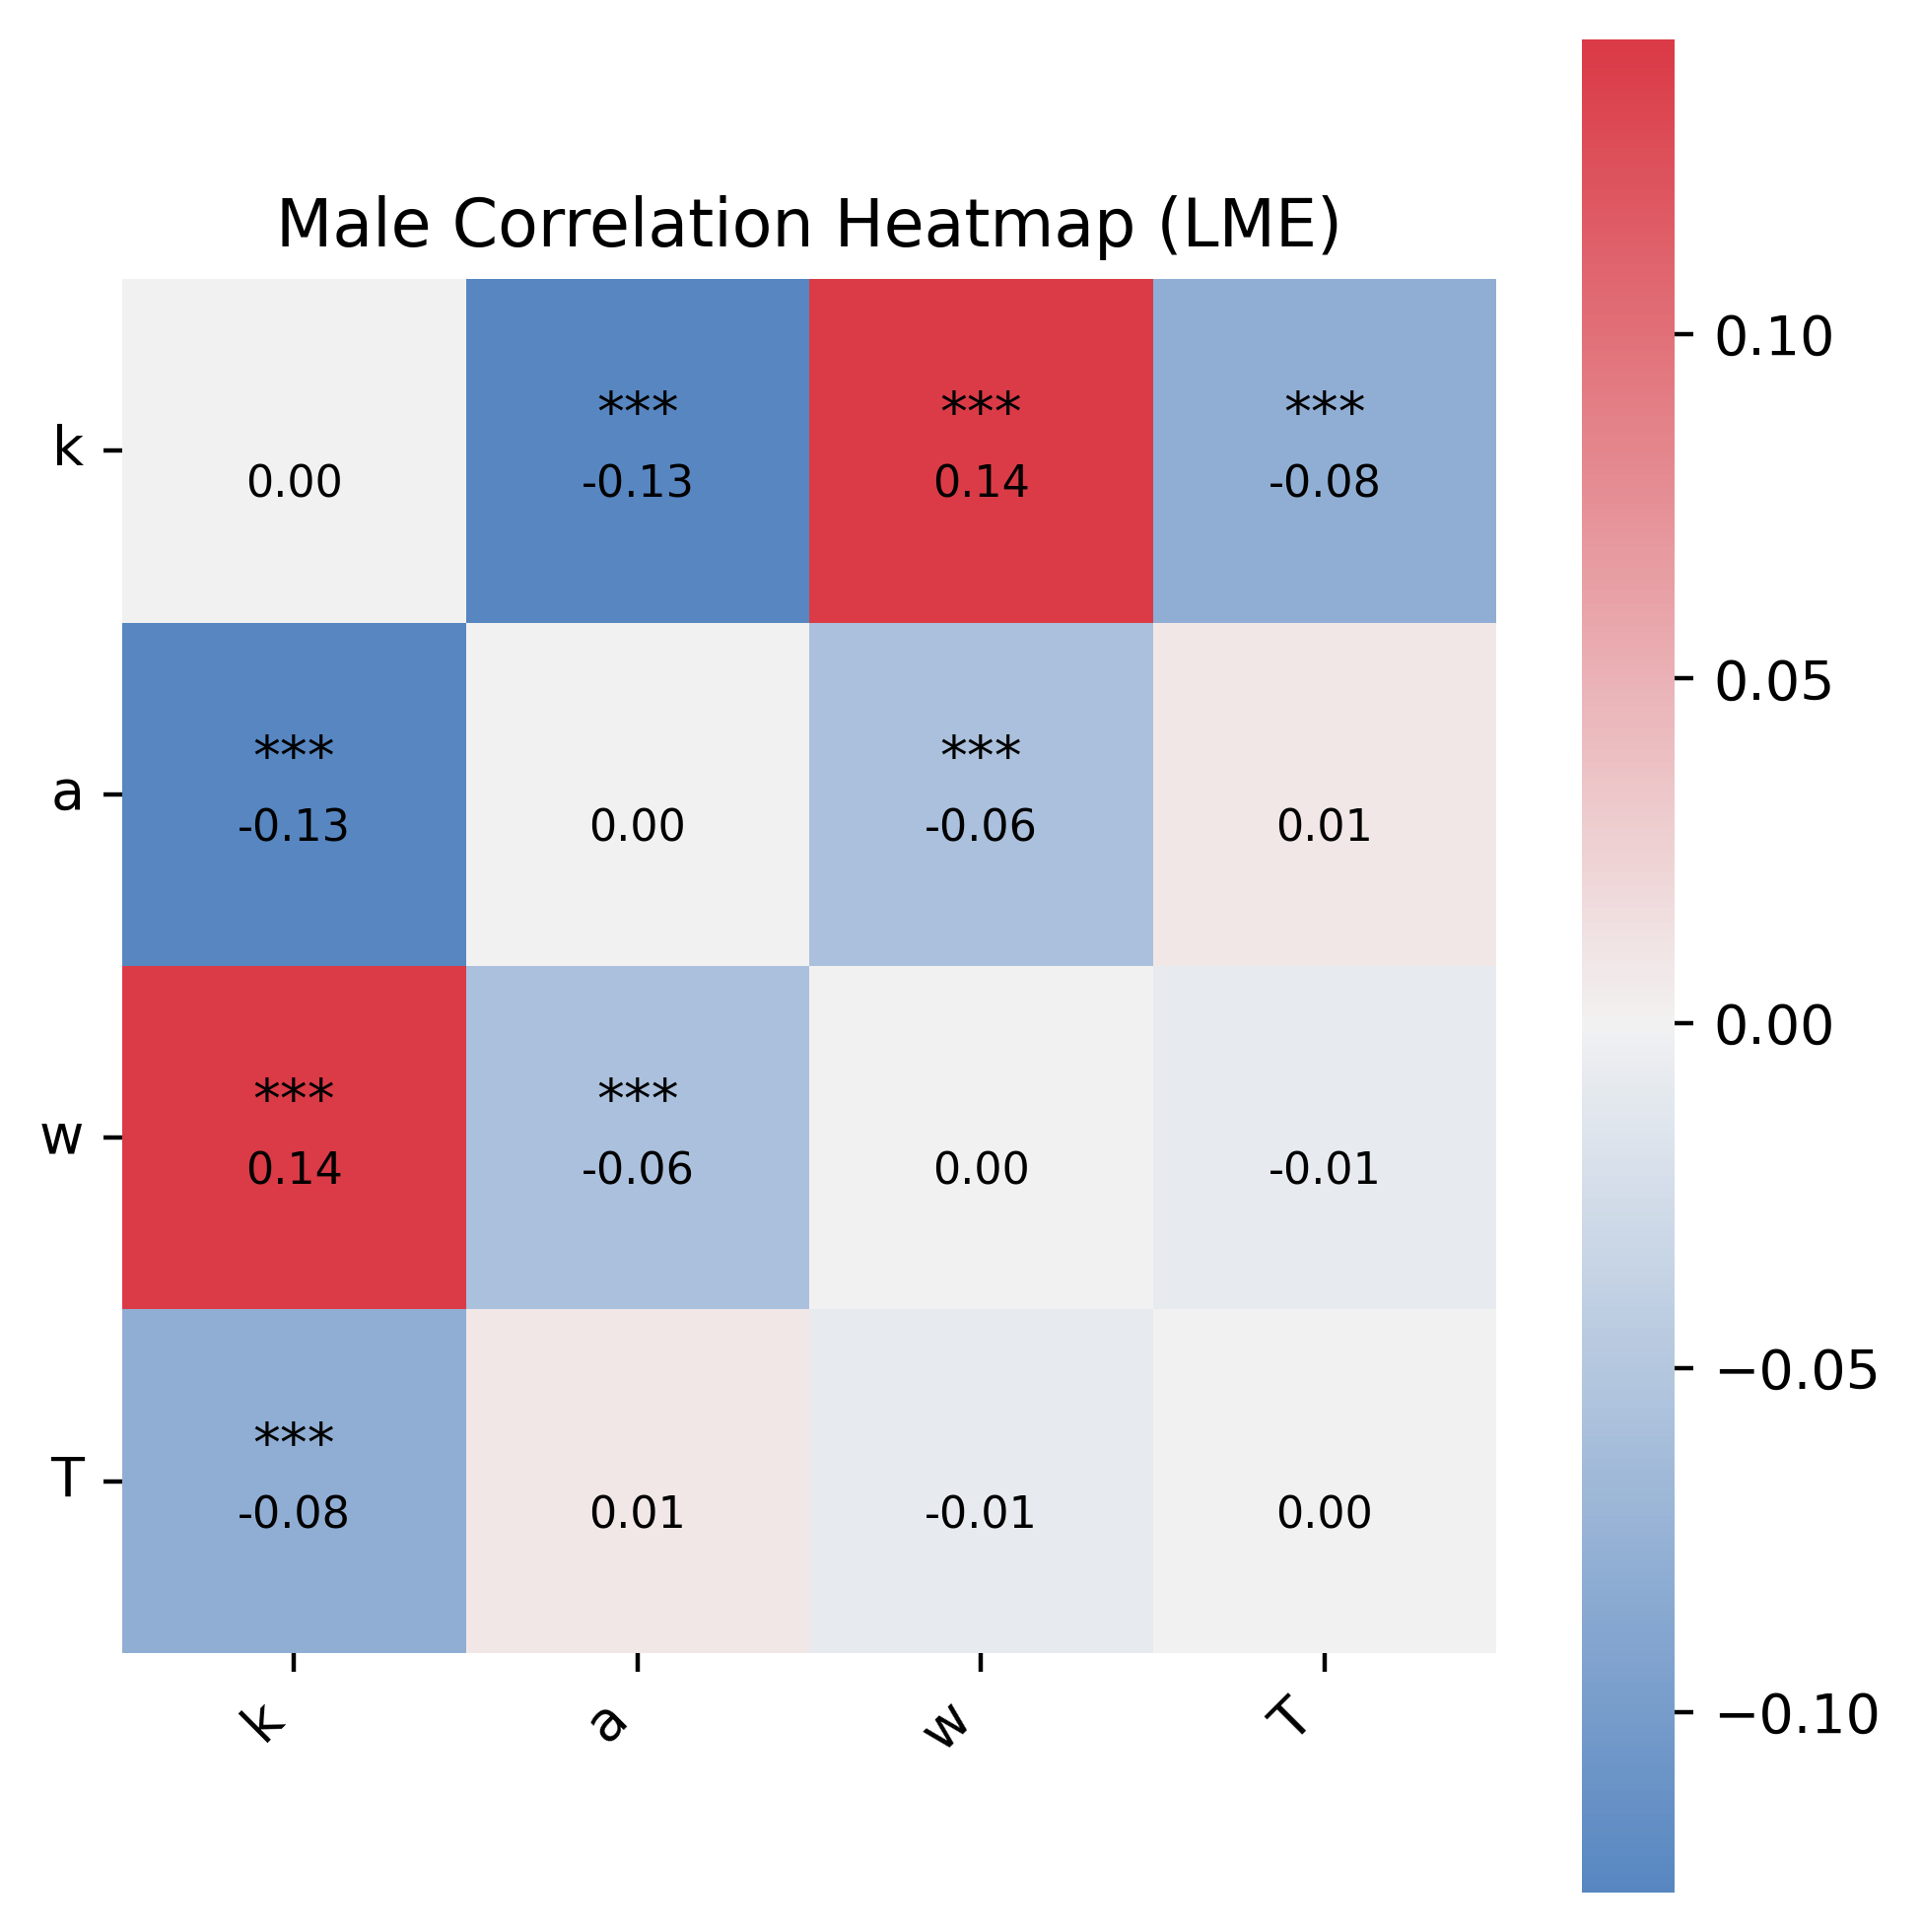

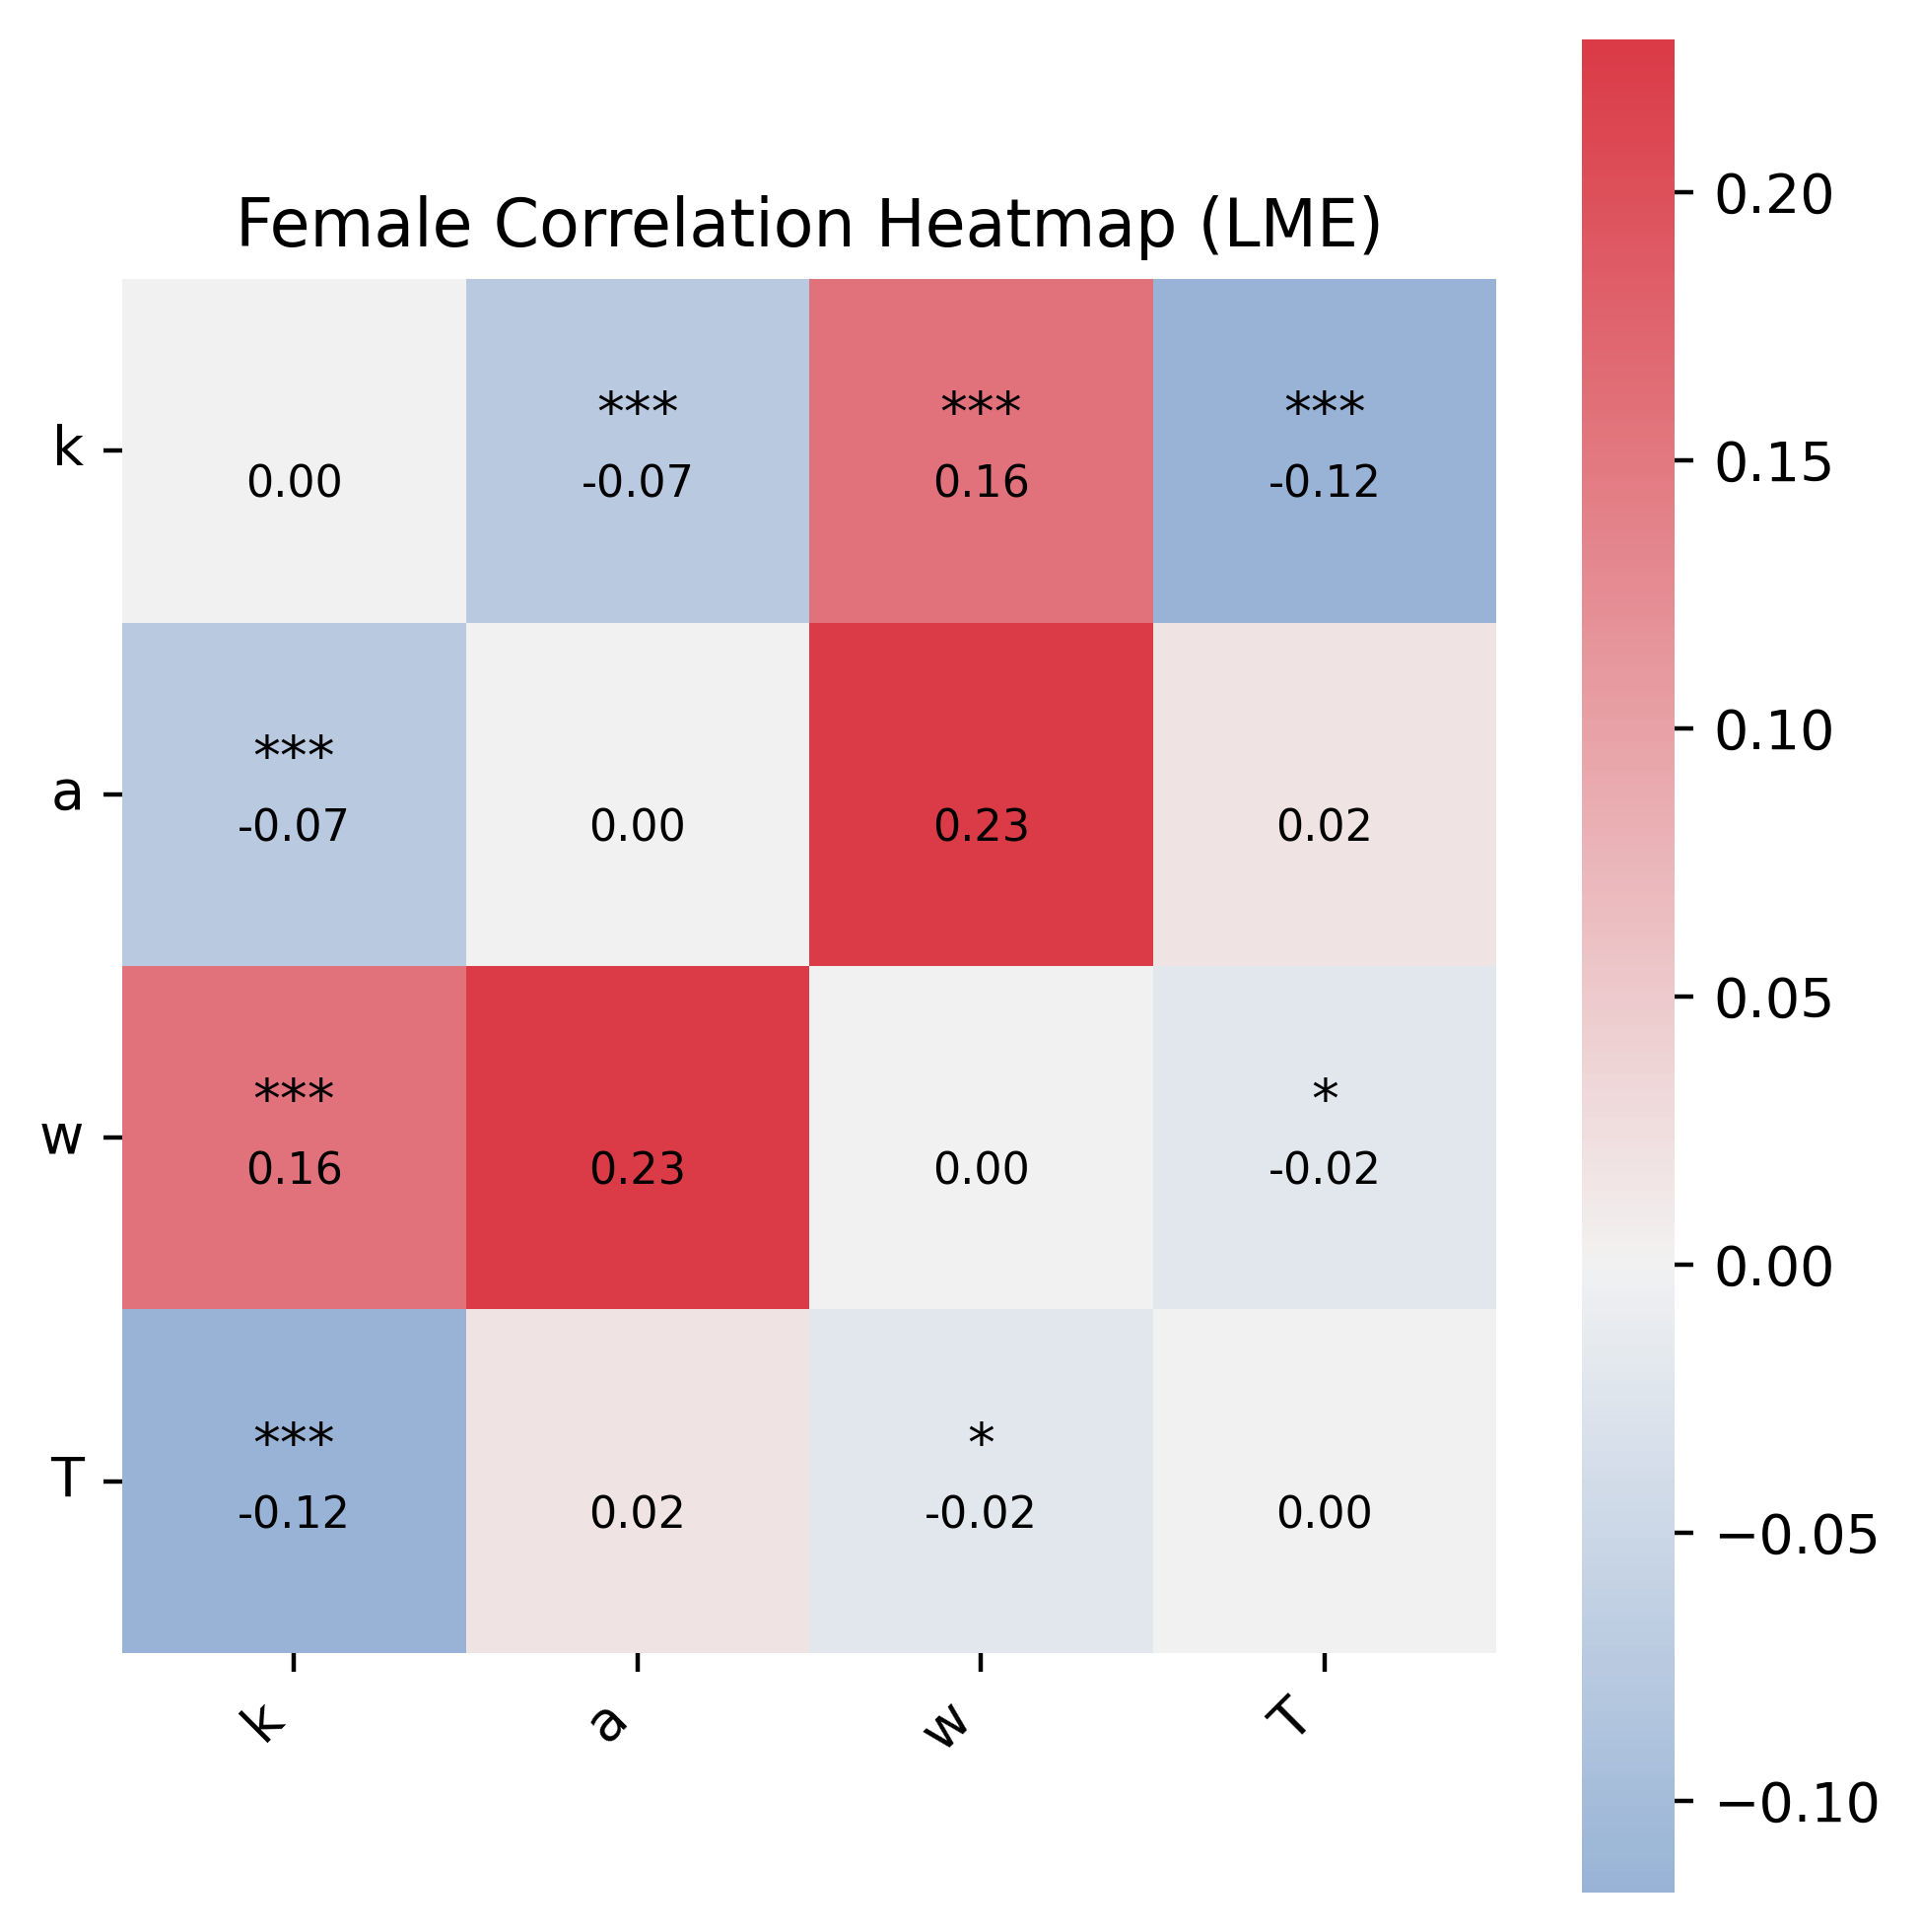

In [5]:
# place the data in the same working envioronment. 
plot_param_correlation_heatmap_lme('init.csv', param_list)

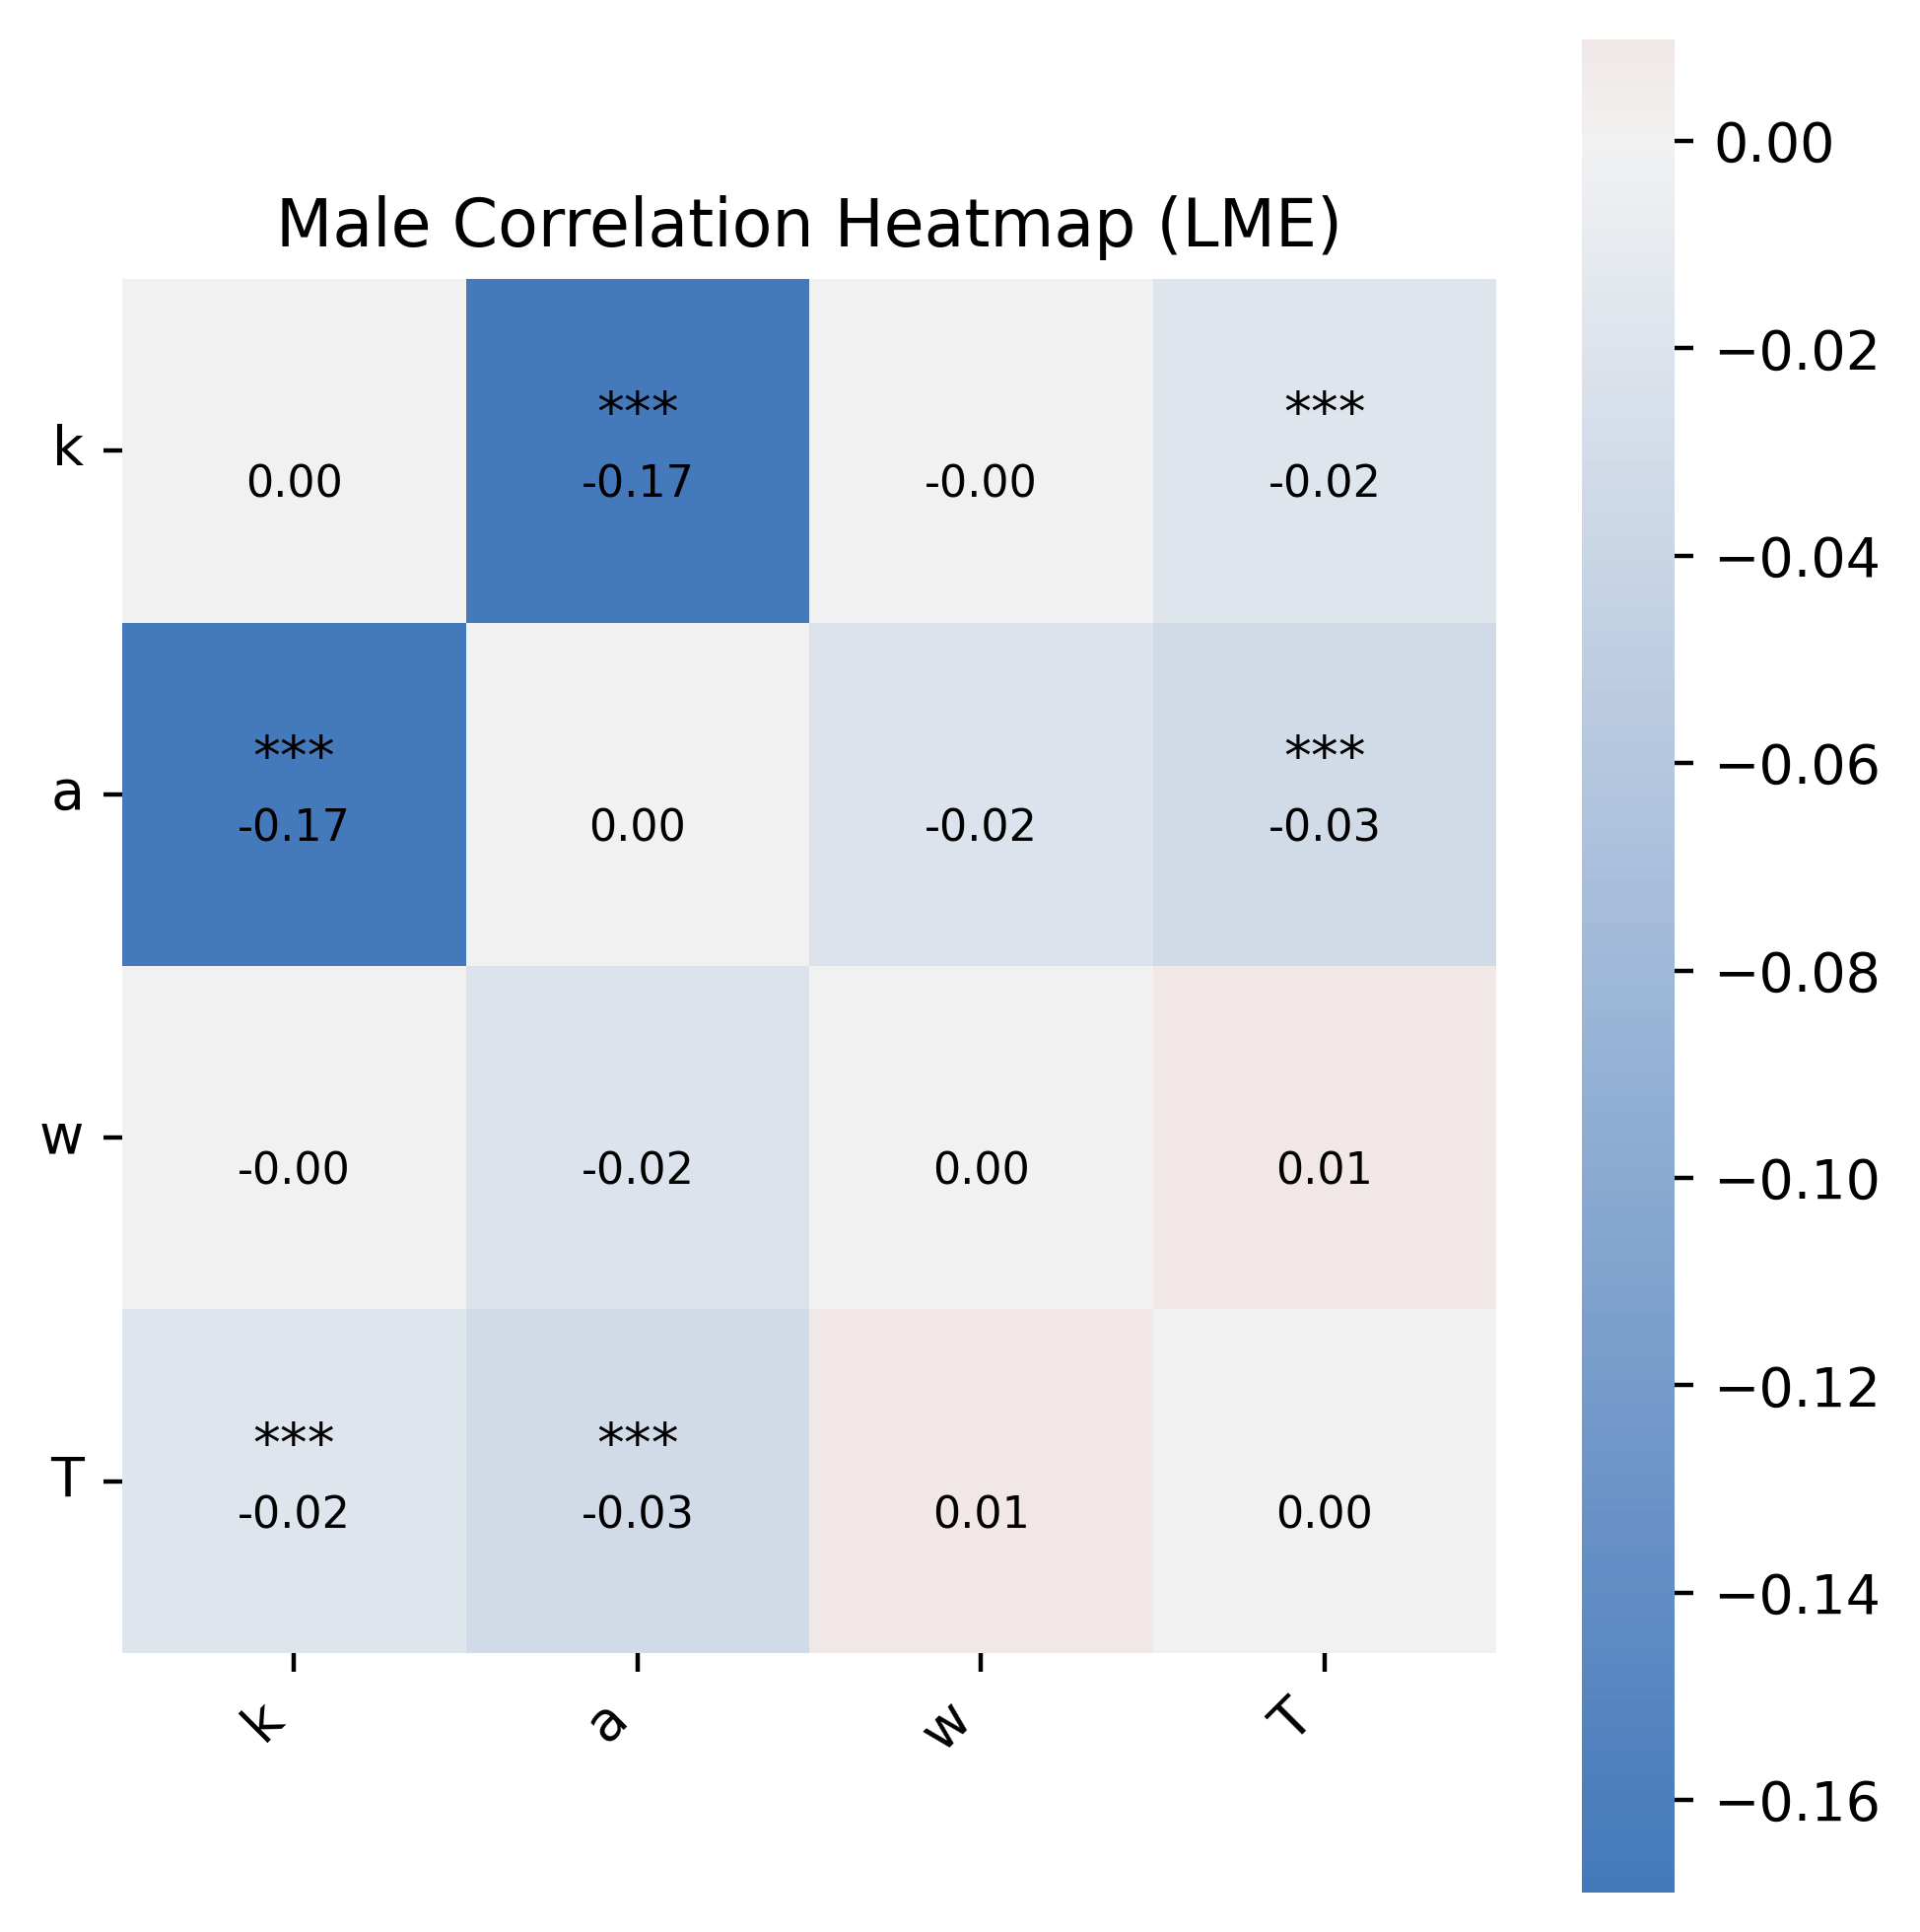

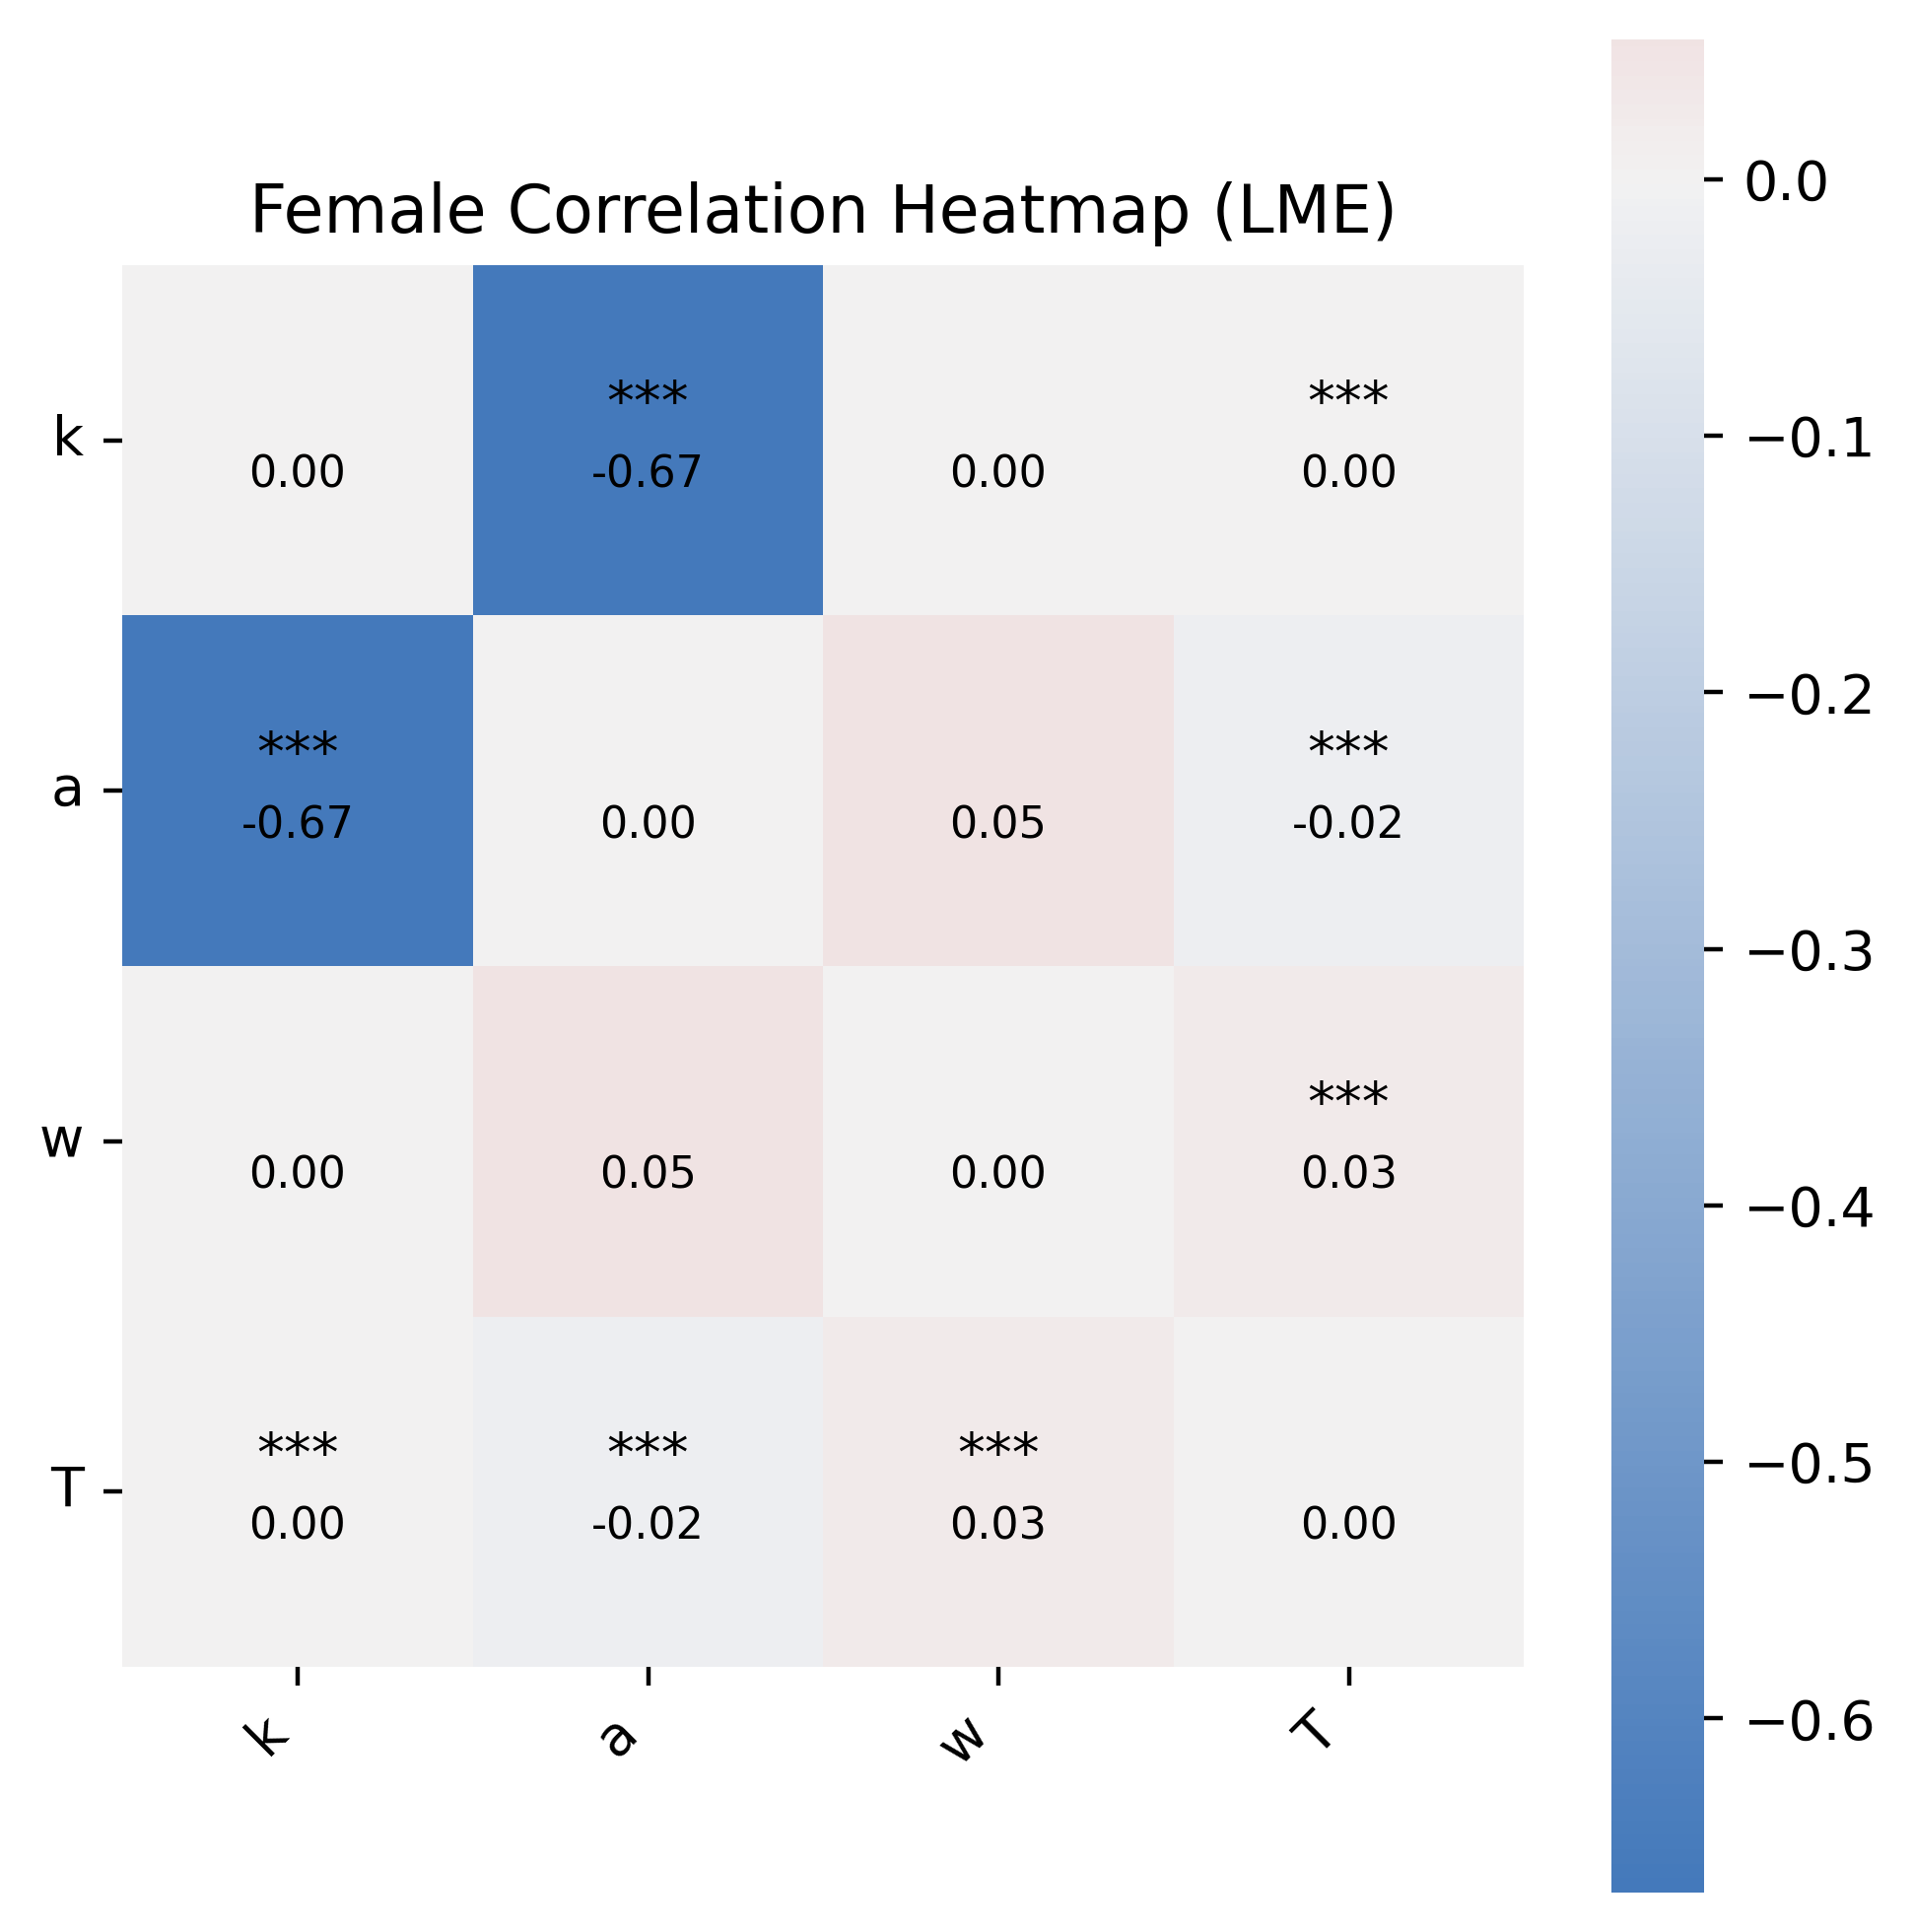

In [6]:
plot_param_correlation_heatmap_lme('choice.csv', param_list)